<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [20]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import plotting_tools as plts
import Residual_blocks as resblock
import Bottleneck_residual_blocks as bresblock
# import history as hist

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete49MZM6/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete49MZM6/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

# x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [6]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 2, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 2, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 2, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 2, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 2, initializer)(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 2, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_26 (ReLU)             (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_27 (ReLU)             (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_28 (ReLU)             (None, 1024)              0   

In [7]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         12409859  
                                                                 
Total params: 26256963 (100.16 MB)
Trainable params: 26236995 (100.09 MB)
Non-trainable params: 19968 (78.00 KB)
_________________________________________________________________


In [ ]:
K.clear_session()

In [8]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75)

Epoch 1/75
391/391 [==============================] - 79s 119ms/step - loss: 0.0403 - val_loss: 0.0337
Epoch 2/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0264 - val_loss: 0.0260
Epoch 3/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 4/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0200 - val_loss: 0.0209
Epoch 5/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0184 - val_loss: 0.0188
Epoch 6/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 7/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 8/75
391/391 [==============================] - 41s 104ms/step - loss: 0.0156 - val_loss: 0.0177
Epoch 9/75
391/391 [==============================] - 41s 104ms/step - loss: 0.0152 - val_loss: 0.0165
Epoch 10/75
391/391 [==============================] - 41s 104ms/step - l

In [9]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75)

Epoch 1/75
391/391 [==============================] - 66s 107ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 2/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0078 - val_loss: 0.0094
Epoch 3/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 4/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 5/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 6/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 7/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0077 - val_loss: 0.0107
Epoch 8/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 9/75
391/391 [==============================] - 40s 103ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 10/75
391/391 [==============================] - 40s 103ms/step - l

In [10]:
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50)

Epoch 1/50
391/391 [==============================] - 66s 108ms/step - loss: 0.0060 - val_loss: 0.0080
Epoch 2/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 3/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 4/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 5/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 6/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0080
Epoch 7/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0060 - val_loss: 0.0079
Epoch 8/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 9/50
391/391 [==============================] - 40s 103ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 10/50
391/391 [==============================] - 40s 103ms/step - l

KeyboardInterrupt: 

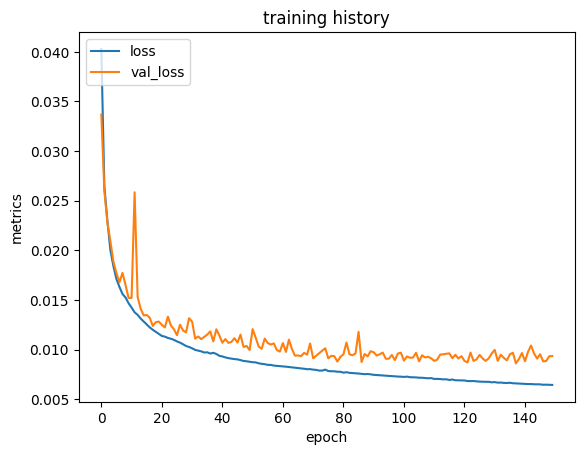

In [17]:
def plot_history(num_sessions, metrics=['loss', 'val_loss']):

		# num_sessions is the number of separate training sessions, should be <= 5
		# metrics are the quantities to be plotted, such as 'loss', 'val_loss', etc, these should be a list of strings

	for metric in metrics:
		if num_sessions == 1:
			plt.plot(history.history[metric])
		elif num_sessions == 2:
			plt.plot(history.history[metric]+history2.history[metric])
		elif num_sessions == 3:
			plt.plot(history.history[metric]+history2.history[metric]+history3.history[metric])
		elif num_sessions == 4:
			plt.plot(history.history[metric]+history2.history[metric]+history3.history[metric]+history4.history[metric])
		elif num_sessions == 5:
			plt.plot(history.history[metric]+history2.history[metric]+history3.history[metric]+history4.history[metric]+history5.history[metric])
		else:
			raise Exception("Too many separate sessions, should be less than 6.")

	plt.title('training history')
	plt.ylabel('metrics')
	plt.xlabel('epoch')

	plt.legend(metrics, loc='upper left')

	plt.show()


plot_history(2)

In [21]:
plts.plot_reconstruction(img_train, 'training', 4, 2, 123, 150)

NameError: name 'tf' is not defined